# Simple Engine

This is a very simple engine example, that requires no additional modules other than those installed with Bamboo.

- Chamber temperature: 2800 K
- Chamber pressure: 10 bar 

- Total propellant mass flow rate: 1 kg/s
- Coolant mass flow rate: 0.2 kg/s

In [1]:
# Import required modules
import cusfbamboo as bam

### Engine Operating Point

Pressures, temperatures, mass flow rates, geometry.

In [2]:
# Chamber conditions
pc = 10e5                   # Chamber pressure (Pa)
Tc = 2800                   # Combustion chamber temperature (K) - would normally get this from an equilibrium program (e.g. Cantera, NASA CEA, ProPEP).

# Geometry properties
Rc = 0.045                  # Chamber radius (m)
Rt = 0.02                   # Throat radius (m)
area_ratio = 4              # Area ratio (A_exit / A_throat)
Lc = 0.10                   # Length of chamber (up to beginning of nozzle converging section) (m)
theta_conv = 45             # Angle of converging section (deg)

# Use the in-built Rao geometry generator
xs, rs = bam.rao.get_rao_contour(r_c = Rc, 
                                 r_t = Rt, 
                                 area_ratio = area_ratio, 
                                 L_c = Lc, 
                                 theta_conv = theta_conv)

### Engine Set Up
We will now use Bamboo to do the cooling system analysis. Will set up:

- Perfect gas model
- Combustion chamber conditions
- Geometry
- Walls
- Exhaust gas transport properties

C:\Users\Daniel\anaconda3\lib\site-packages\numpy\lib\function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\Daniel\anaconda3\lib\site-packages\numpy\lib\function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\Daniel\anaconda3\lib\site-packages\numpy\lib\function_base.py:1075: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\Daniel\anaconda3\lib\site-packages\numpy\lib\function_base.py:1081: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


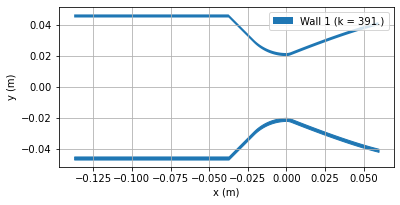

Sea Level Thrust = 1482.1183659424805 N
Sea Level Specific Impulse = 1307.2811488280518 m/s


In [3]:
# Set up the objects we need
perfect_gas = bam.PerfectGas(gamma = 1.31, cp = 830)                   # Approximate values for CO2
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
geometry = bam.Geometry(xs = xs, rs = rs)
exhaust_transport = bam.materials.CO2                                  # Use the built-in CO2 approximation
wall = bam.Wall(material = bam.materials.CopperC106, thickness = 2e-3) # Use the built in C106 copper data

# Submit them all at inputs to the Engine object
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    exhaust_transport = exhaust_transport,
                    walls = wall)
engine.plot()
bam.show()

print(f"Sea Level Thrust = {engine.thrust(p_amb = 1e5)} N")
print(f"Sea Level Specific Impulse = {engine.isp(p_amb = 1e5)} m/s")

### Cooling Jacket

Add the cooling channel details. We will use 'vertical' channels (`configuration = 'vertical'` as opposed to `configuration = 'spiral'`). This image is an example of 'vertical' channels: https://slideplayer.com/slide/4179683/14/images/6/Cooling+Channels.jpg

In [4]:
# Cooling jacket properties
inlet_T = 298.15                           # Coolant inlet static temperature (K)
inlet_p = 30e5                             # Coolant inlet static pressure (bar)
OF_ratio = 3.5                             # Oxidiser/fuel mass ratio
mdot_coolant = 0.5                         # Coolant mass flow rate (kg/s)

# Add a cooling jacket to the engine
engine.cooling_jacket = bam.CoolingJacket(T_coolant_in = inlet_T, 
                                         p_coolant_in = inlet_p, 
                                         mdot_coolant = mdot_coolant, 
                                         channel_height = 2e-3,
                                         blockage_ratio = 0.5,
                                         number_of_channels = 100,
                                         coolant_transport = bam.materials.Water,   # Use bamboo's built-in water approximation
                                         configuration = 'vertical')



### Run Cooling Analysis

In [7]:
# Run the heating analysis - see the documentation for details on the various arguments.
cooling_data = engine.steady_heating_analysis(iter_each = 5)

C:\Users\Daniel\anaconda3\lib\site-packages\cusfbamboo\hx.py:84: UserWarning: ReDh < 3500 in cooling channels: Flow is in between the laminar and turbulent regions - blending will be used. Constant wall temperature is assumed for laminar Nusselt number.
  R = self.Rdx(self.state[i]))
C:\Users\Daniel\anaconda3\lib\site-packages\cusfbamboo\hx.py:84: UserWarning: ReDh < 2300 in cooling channels: Laminar flow relations will be used. Constant wall temperature is assumed for Nusselt number.
  R = self.Rdx(self.state[i]))


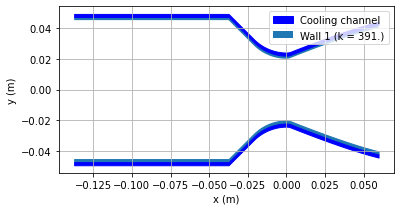

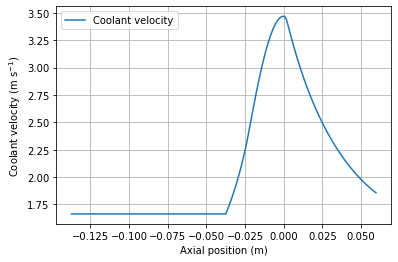

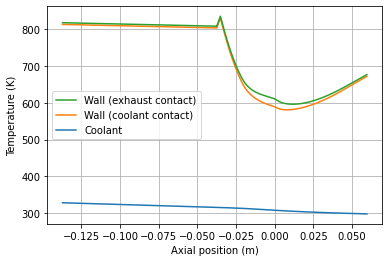

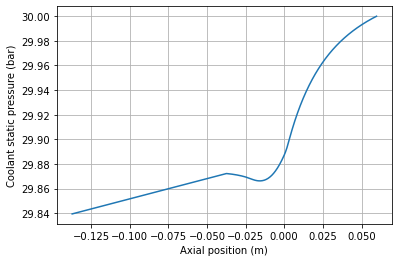

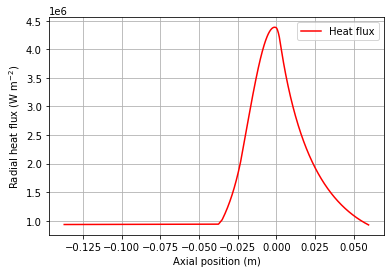

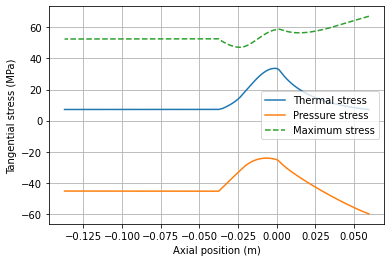

In [8]:
# Use the built in plotting functions to quickly generate some plots
engine.plot()
bam.show()

bam.plot.plot_coolant_velocity(cooling_data)
bam.show()

bam.plot.plot_temperatures(cooling_data, only_indexes = [0, 1, 2])   # Exclude the exhaust gas temperature from the plot
bam.show()

bam.plot.plot_p_coolant(cooling_data)
bam.show()

bam.plot.plot_q_per_area(cooling_data)
bam.show()

bam.plot.plot_tangential_stress(cooling_data, wall_index = 0)
bam.show()